# Car Purchase Decision Analysis
## Volkswagen ID.4 Pro AWD vs Alternatives

This notebook analyzes:
- VW ID.4 Pro AWD with V2H (Vehicle-to-Home)
- VW ID.4 Pro AWD without V2H
- Plugin Hybrid (similar size)
- Gasoline car (similar size)

**Current vehicle:** Toyota Prius V 2017  
**Annual driving:** 20,000 km  
**Location:** 4250 rue Belanger, Montreal, QC  
**Solar investment:** $7,000 CAD

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from ipywidgets import interactive, FloatSlider, IntSlider
from IPython.display import display
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Hydro-Quebec Credentials and Data

In [2]:
# Load credentials from .env file (DO NOT COMMIT THIS FILE)
# Create a file named '.env' in the same directory with:
# HYDRO_USERNAME=your_username
# HYDRO_PASSWORD=your_password
#
# Optional (hydroqc can usually retrieve these after login):
# HYDRO_CONTRACT_ID=your_contract_id
# HYDRO_CUSTOMER_ID=your_customer_id

load_dotenv()

credentials = {
    'username': os.getenv('HYDRO_USERNAME'),
    'password': os.getenv('HYDRO_PASSWORD'),
    'contract_id': os.getenv('HYDRO_CONTRACT_ID'),  # Optional
    'customer_id': os.getenv('HYDRO_CUSTOMER_ID')   # Optional
}

# Check if minimum credentials are loaded (username and password)
if credentials['username'] and credentials['password']:
    print("✓ Credentials loaded successfully from .env file")
    if not credentials['contract_id'] or not credentials['customer_id']:
        print("ℹ Contract/Customer IDs not provided - hydroqc will attempt to retrieve them")
else:
    print("⚠ Warning: .env file not found or incomplete. Using sample data.")
    print("   Minimum required: HYDRO_USERNAME and HYDRO_PASSWORD")
    credentials = None

⚠ Warning: .env file not found or incomplete. Using sample data.
   Minimum required: HYDRO_USERNAME and HYDRO_PASSWORD


In [3]:
# Function to fetch Hydro-Quebec data
def fetch_hydro_data(credentials):
    """
    Fetch historical electricity consumption from Hydro-Quebec API
    Using hydroqc library: https://gitlab.com/hydroqc/hydroqc
    
    The library typically only needs username and password.
    After login, it can retrieve customer and contract IDs automatically.
    """
    if credentials is None:
        # Return sample data for demonstration
        print("Using sample data - replace with actual Hydro-Quebec data")
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        # Typical Montreal home consumption (kWh) - higher in winter
        consumption = [1800, 1650, 1400, 1100, 850, 650, 
                       550, 580, 700, 950, 1250, 1600]
        return pd.DataFrame({
            'month': months,
            'consumption_kwh': consumption,
            'month_num': range(1, 13)
        })
    
    try:
        # Uncomment and use when credentials are available
        # Note: This is async code - you may need to adapt for Jupyter
        # 
        # from hydroqc import HydroQuebecClient
        # import asyncio
        # 
        # async def get_data():
        #     client = HydroQuebecClient(
        #         credentials['username'],
        #         credentials['password'],
        #         timeout=60
        #     )
        #     await client.login()
        #     
        #     # If contract_id and customer_id provided, use them
        #     # Otherwise, retrieve the first available account
        #     if credentials.get('customer_id') and credentials.get('contract_id'):
        #         customer = await client.get_customer(
        #             credentials['customer_id'], 
        #             credentials['contract_id']
        #         )
        #     else:
        #         # Get first available customer/contract
        #         customers = await client.get_customers()
        #         customer = customers[0] if customers else None
        #     
        #     if customer:
        #         consumption_data = await customer.get_annual_consumption()
        #         # Process and return the data
        #         return process_consumption_data(consumption_data)
        #     return None
        # 
        # # Run async function in Jupyter
        # return asyncio.run(get_data())
        pass
    except Exception as e:
        print(f"Error fetching Hydro-Quebec data: {e}")
        return None

# Fetch data
hydro_data = fetch_hydro_data(credentials)
display(hydro_data)

Using sample data - replace with actual Hydro-Quebec data


,month,consumption_kwh,month_num
0,Jan,1800,1
1,Feb,1650,2
2,Mar,1400,3
3,Apr,1100,4
4,May,850,5
5,Jun,650,6
6,Jul,550,7
7,Aug,580,8
8,Sep,700,9
9,Oct,950,10


## 2. Define Constants and Parameters

In [4]:
# VEHICLE SPECIFICATIONS
VEHICLES = {
    'VW ID.4 Pro AWD': {
        'type': 'BEV',
        'battery_kwh': 82,
        'usable_battery_kwh': 77,  # ~94% usable
        'range_km': 443,  # EPA estimate
        'efficiency_kwh_per_100km': 19.5,  # Real-world average
        'price_cad': 54995,  # 2024 MSRP
        'v2h_capable': True,
        'max_v2h_power_kw': 11.5  # Bidirectional charging capability
    },
    'Plugin Hybrid': {
        'type': 'PHEV',
        'battery_kwh': 17.9,  # e.g., Toyota RAV4 Prime
        'usable_battery_kwh': 14.5,
        'electric_range_km': 68,
        'efficiency_kwh_per_100km': 21.5,  # Electric mode
        'fuel_efficiency_l_per_100km': 7.2,  # Hybrid mode
        'price_cad': 47500,
        'v2h_capable': False
    },
    'Gasoline SUV': {
        'type': 'ICE',
        'fuel_efficiency_l_per_100km': 9.5,  # Similar size SUV
        'price_cad': 38000,
        'v2h_capable': False
    },
    'Current Prius V': {
        'type': 'Hybrid',
        'fuel_efficiency_l_per_100km': 6.5,
        'price_cad': 0,  # Already owned
        'v2h_capable': False
    }
}

# ENERGY COSTS
ELECTRICITY_RATES = {
    'tier1_rate': 0.0662,  # $/kWh first 40 kWh/day (Rate D)
    'tier2_rate': 0.1014,  # $/kWh above 40 kWh/day
    'tier1_daily_limit': 40,
    'flex_d_peak_rate': 0.1078,  # $/kWh during peak (winter AM/PM) - Flex D 2024
    'flex_d_offpeak_rate': 0.0400,  # $/kWh off-peak - Flex D 2024
    'daily_charge': 0.4246  # Daily service charge
}

GASOLINE_PRICE = 1.65  # $/L (CAD, average Montreal 2024)

# SOLAR SYSTEM PARAMETERS
SOLAR_PARAMS = {
    'system_size_kw': 5.0,  # Realistic for $7k budget
    'installation_cost': 7000,  # CAD
    'degradation_rate': 0.005,  # 0.5% per year
    'efficiency': 0.80,  # System efficiency including inverter losses
    # Monthly solar production factors for Montreal (relative to peak summer)
    'monthly_production': [0.45, 0.55, 0.70, 0.85, 0.95, 1.00,
                          0.98, 0.90, 0.75, 0.58, 0.40, 0.35],
    'annual_kwh_per_kw': 1150  # Montreal average
}

# GOVERNMENT INCENTIVES (2026 - Current as of January 2026)
INCENTIVES = {
    # Federal iZEV program (active through March 2025, status for 2026 uncertain)
    # Update: Program ended March 31, 2024 - no longer available
    'federal_ev': 0,  # iZEV program ended - set to 0
    
    # Quebec Roulez vert (extended through 2027)
    'quebec_ev': 7000,  # BEV rebate (vehicles under $65,000)
    'quebec_phev': 3500,  # PHEV rebate
    
    # Home charger rebates
    'federal_home_charger': 0,  # Federal program ended
    'quebec_home_charger': 600,  # Quebec - up to $600 for Level 2 charger
    
    # Solar incentives
    'federal_solar': 5000,  # Canada Greener Homes Grant (still active)
    'quebec_solar_per_watt': 0.37,  # $0.37/W up to certain limits
    'quebec_solar_max': 1850,  # Maximum Quebec solar rebate
}

# MAINTENANCE COSTS (annual)
MAINTENANCE = {
    'BEV': 500,  # Lower maintenance for EVs (no oil changes, brake pads last longer)
    'PHEV': 800,  # Combined gas + electric
    'ICE': 1200,  # Traditional maintenance
    'Hybrid': 900
}

# TIRE COSTS (Quebec requires winter tires + EVs wear tires faster due to weight)
TIRE_COSTS = {
    'BEV': {
        'summer_set': 1200,  # EV-rated tires are more expensive
        'winter_set': 1100,
        'installation_per_swap': 80,  # Twice per year
        'summer_lifespan_years': 3,  # EVs wear tires ~20% faster
        'winter_lifespan_years': 4,
        'swaps_per_year': 2
    },
    'PHEV': {
        'summer_set': 900,
        'winter_set': 850,
        'installation_per_swap': 80,
        'summer_lifespan_years': 4,
        'winter_lifespan_years': 5,
        'swaps_per_year': 2
    },
    'ICE': {
        'summer_set': 800,
        'winter_set': 750,
        'installation_per_swap': 80,
        'summer_lifespan_years': 4,
        'winter_lifespan_years': 5,
        'swaps_per_year': 2
    },
    'Hybrid': {
        'summer_set': 800,
        'winter_set': 750,
        'installation_per_swap': 80,
        'summer_lifespan_years': 4,
        'winter_lifespan_years': 5,
        'swaps_per_year': 2
    }
}

# CHARGER INSTALLATION COSTS
CHARGER_COSTS = {
    'level2_standard': 1500,  # Standard Level 2 charger + installation
    'level2_v2h': 8500,  # V2H-capable bidirectional charger + installation
    'quebec_rebate': 600  # Roulez vert charger rebate
}

# SOLAR INSTALLATION (included in solar_cost parameter but broken down here)
SOLAR_INSTALLATION = {
    'equipment_per_kw': 1000,  # Panels, inverter, mounting
    'installation_per_kw': 400,  # Labor, electrical, permits
    'total_per_kw': 1400  # $7000 for 5kW system
}

# MONTREAL CLIMATE DATA
MONTREAL_TEMPS = [-10, -8, -2, 6, 14, 19, 22, 21, 16, 9, 2, -6]  # Avg monthly temp °C

print("✓ Constants loaded")

✓ Constants loaded


## 2a. Tire Cost Calculations

In [5]:
def calculate_annual_tire_cost(vehicle_type):
    """
    Calculate annualized tire costs for Quebec
    Includes:
    - Summer tire replacement (amortized over lifespan)
    - Winter tire replacement (amortized over lifespan)  
    - Seasonal installation/swap costs (2x per year)
    
    EVs typically wear tires 20-30% faster due to:
    - Higher weight (battery)
    - Instant torque
    - Regenerative braking
    """
    tire_spec = TIRE_COSTS[vehicle_type]
    
    # Amortize tire set costs over their lifespan
    annual_summer_cost = tire_spec['summer_set'] / tire_spec['summer_lifespan_years']
    annual_winter_cost = tire_spec['winter_set'] / tire_spec['winter_lifespan_years']
    
    # Seasonal swap costs (2 per year in Quebec)
    annual_swap_cost = tire_spec['installation_per_swap'] * tire_spec['swaps_per_year']
    
    total_annual = annual_summer_cost + annual_winter_cost + annual_swap_cost
    
    return {
        'summer_amortized': annual_summer_cost,
        'winter_amortized': annual_winter_cost,
        'swaps': annual_swap_cost,
        'total_annual': total_annual
    }

# Show tire costs for each vehicle type
print("Annual Tire Costs (Quebec - includes winter tires):\n")
for vtype in ['BEV', 'PHEV', 'ICE', 'Hybrid']:
    costs = calculate_annual_tire_cost(vtype)
    print(f"{vtype:8s}: ${costs['total_annual']:>6.0f}/year")
    print(f"          (Summer: ${costs['summer_amortized']:.0f}, "
          f"Winter: ${costs['winter_amortized']:.0f}, "
          f"Swaps: ${costs['swaps']:.0f})")
print("\n✓ Tire costs calculated")

Annual Tire Costs (Quebec - includes winter tires):

BEV     : $   835/year
          (Summer: $400, Winter: $275, Swaps: $160)
PHEV    : $   555/year
          (Summer: $225, Winter: $170, Swaps: $160)
ICE     : $   510/year
          (Summer: $200, Winter: $150, Swaps: $160)
Hybrid  : $   510/year
          (Summer: $200, Winter: $150, Swaps: $160)

✓ Tire costs calculated


## 3. Calculate Solar Production

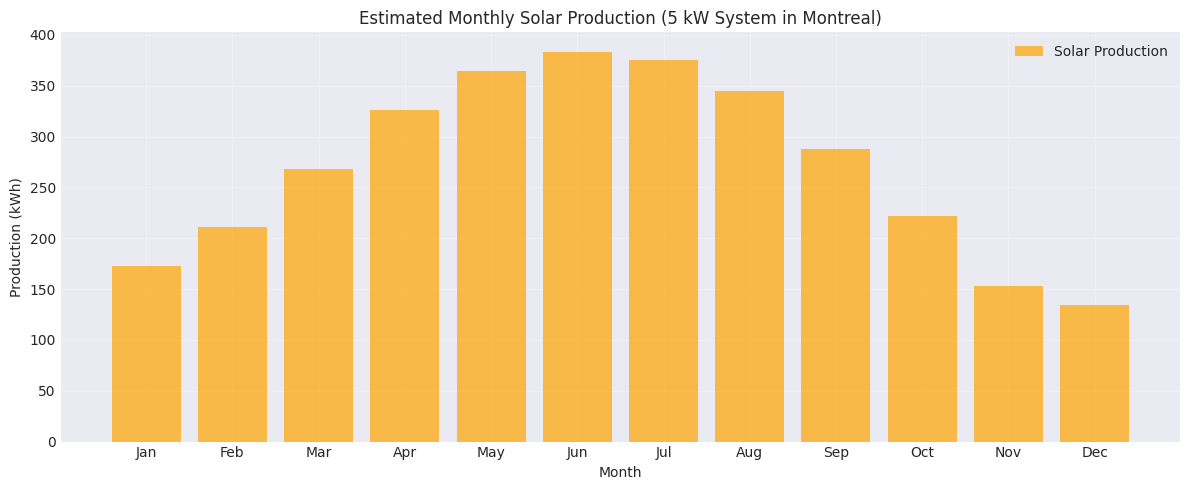

Total annual solar production: 3243 kWh


In [6]:
def calculate_solar_production(system_size_kw, year=0):
    """
    Calculate monthly solar production for a given system size
    Accounts for seasonal variation and system degradation
    """
    annual_production = system_size_kw * SOLAR_PARAMS['annual_kwh_per_kw']
    degradation = (1 - SOLAR_PARAMS['degradation_rate']) ** year
    
    monthly_production = []
    for factor in SOLAR_PARAMS['monthly_production']:
        monthly_kwh = (annual_production / 12) * factor * degradation * SOLAR_PARAMS['efficiency']
        monthly_production.append(monthly_kwh)
    
    return monthly_production

# Calculate first year solar production
solar_production_monthly = calculate_solar_production(SOLAR_PARAMS['system_size_kw'])

# Visualize solar production
fig, ax = plt.subplots(figsize=(12, 5))
months = hydro_data['month']
ax.bar(months, solar_production_monthly, alpha=0.7, color='orange', label='Solar Production')
ax.set_xlabel('Month')
ax.set_ylabel('Production (kWh)')
ax.set_title('Estimated Monthly Solar Production (5 kW System in Montreal)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total annual solar production: {sum(solar_production_monthly):.0f} kWh")

## 4. Energy Cost Calculations

In [7]:
def calculate_electricity_cost(monthly_kwh, solar_kwh=0, has_flex_rate=False):
    """
    Calculate monthly electricity cost using Hydro-Quebec Rate D or Flex D
    Accounts for tiered pricing and net metering
    """
    net_consumption = max(0, monthly_kwh - solar_kwh)
    days_in_month = 30.4  # Average
    daily_consumption = net_consumption / days_in_month
    
    if has_flex_rate:
        # Flex D: assumes 40% peak, 60% off-peak
        peak_kwh = net_consumption * 0.4
        offpeak_kwh = net_consumption * 0.6
        energy_cost = (peak_kwh * ELECTRICITY_RATES['flex_d_peak_rate'] + 
                      offpeak_kwh * ELECTRICITY_RATES['flex_d_offpeak_rate'])
    else:
        # Rate D with tiered pricing
        tier1_kwh = min(daily_consumption, ELECTRICITY_RATES['tier1_daily_limit']) * days_in_month
        tier2_kwh = max(0, net_consumption - tier1_kwh)
        energy_cost = (tier1_kwh * ELECTRICITY_RATES['tier1_rate'] + 
                      tier2_kwh * ELECTRICITY_RATES['tier2_rate'])
    
    daily_charges = ELECTRICITY_RATES['daily_charge'] * days_in_month
    total_cost = energy_cost + daily_charges
    
    return total_cost

def calculate_vehicle_energy_cost(vehicle, annual_km, solar_available=False):
    """
    Calculate annual energy cost for a vehicle
    """
    monthly_km = annual_km / 12
    
    if vehicle['type'] == 'BEV':
        # Pure electric
        kwh_per_month = monthly_km * vehicle['efficiency_kwh_per_100km'] / 100
        
        # Apply temperature correction (battery less efficient in cold)
        temp_corrections = [1.3, 1.25, 1.15, 1.05, 1.0, 1.0, 
                           1.0, 1.0, 1.0, 1.05, 1.15, 1.25]
        
        monthly_costs = []
        for month in range(12):
            adjusted_kwh = kwh_per_month * temp_corrections[month]
            solar_kwh = solar_production_monthly[month] if solar_available else 0
            cost = calculate_electricity_cost(adjusted_kwh, solar_kwh * 0.5)  # 50% goes to car
            monthly_costs.append(cost)
        
        return sum(monthly_costs)
    
    elif vehicle['type'] == 'PHEV':
        # Assume 70% of km driven electric, 30% on gas
        electric_km = monthly_km * 0.7
        gas_km = monthly_km * 0.3
        
        kwh_per_month = electric_km * vehicle['efficiency_kwh_per_100km'] / 100
        liters_per_month = gas_km * vehicle['fuel_efficiency_l_per_100km'] / 100
        
        monthly_costs = []
        for month in range(12):
            solar_kwh = solar_production_monthly[month] if solar_available else 0
            electric_cost = calculate_electricity_cost(kwh_per_month, solar_kwh * 0.5)
            gas_cost = liters_per_month * GASOLINE_PRICE
            monthly_costs.append(electric_cost + gas_cost)
        
        return sum(monthly_costs)
    
    else:  # ICE or Hybrid
        liters_per_month = monthly_km * vehicle['fuel_efficiency_l_per_100km'] / 100
        return liters_per_month * 12 * GASOLINE_PRICE

print("✓ Energy cost functions defined")

✓ Energy cost functions defined


## 5. V2H Backup Power Analysis

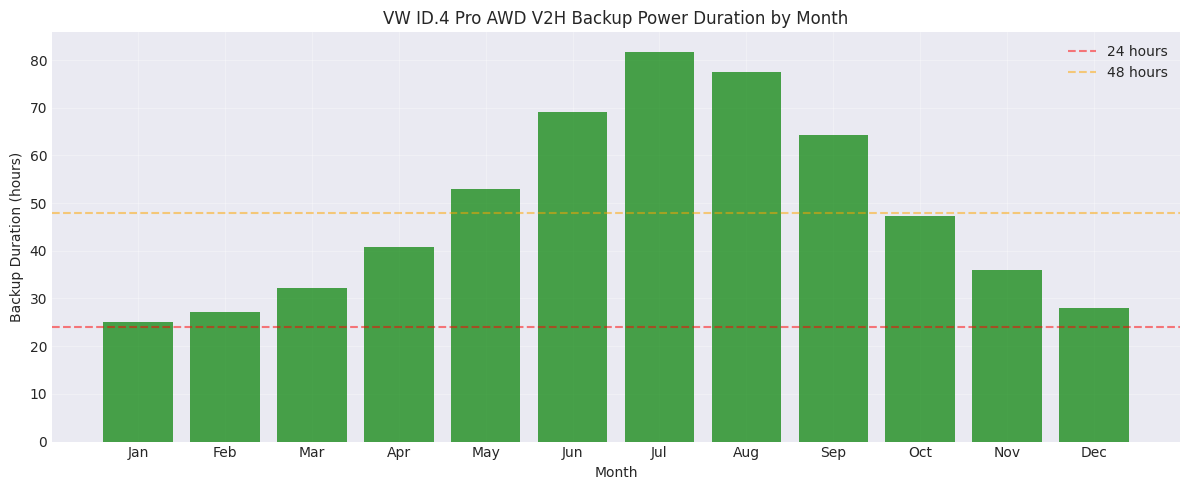

Average backup power: 48.5 hours
Minimum backup (winter): 25.0 hours
Maximum backup (summer): 81.7 hours


In [8]:
def calculate_v2h_backup_hours(vehicle, month_idx):
    """
    Calculate backup power duration from V2H system
    Considers:
    - Vehicle battery state (assume 80% available for home backup)
    - Monthly home consumption
    - Solar contribution during daylight hours
    """
    if not vehicle.get('v2h_capable', False):
        return 0
    
    # Available battery for home backup (keep 20% for emergency driving)
    available_kwh = vehicle['usable_battery_kwh'] * 0.8
    
    # Average hourly consumption
    monthly_consumption = hydro_data.iloc[month_idx]['consumption_kwh']
    avg_hourly_consumption = monthly_consumption / (30.4 * 24)
    
    # Solar contribution (only during ~8 hours of daylight)
    daily_solar = solar_production_monthly[month_idx] / 30.4
    hourly_solar_contribution = daily_solar / 8  # Spread over daylight hours
    
    # Net consumption (assume outage during day)
    net_hourly_consumption = max(0, avg_hourly_consumption - hourly_solar_contribution)
    
    # Backup duration
    backup_hours = available_kwh / avg_hourly_consumption if avg_hourly_consumption > 0 else 0
    
    return backup_hours

# Calculate backup hours for each month
v2h_backup_hours = [calculate_v2h_backup_hours(VEHICLES['VW ID.4 Pro AWD'], i) 
                    for i in range(12)]

# Visualize backup capacity
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(months, v2h_backup_hours, alpha=0.7, color='green')
ax.set_xlabel('Month')
ax.set_ylabel('Backup Duration (hours)')
ax.set_title('VW ID.4 Pro AWD V2H Backup Power Duration by Month')
ax.axhline(y=24, color='r', linestyle='--', label='24 hours', alpha=0.5)
ax.axhline(y=48, color='orange', linestyle='--', label='48 hours', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average backup power: {np.mean(v2h_backup_hours):.1f} hours")
print(f"Minimum backup (winter): {min(v2h_backup_hours):.1f} hours")
print(f"Maximum backup (summer): {max(v2h_backup_hours):.1f} hours")

## 6. V2H Rate Arbitrage Analysis

In [9]:
def calculate_v2h_arbitrage_savings(vehicle, has_solar=True):
    """
    Calculate potential savings from using V2H to arbitrage electricity rates
    Strategy:
    1. Charge battery from solar during day
    2. Use battery to power home during peak rate periods
    3. Charge from grid during off-peak if needed
    
    Note: Savings are modest - V2H is primarily valuable for backup power,
    not significant cost savings.
    """
    if not vehicle.get('v2h_capable', False):
        return 0
    
    # Conservative assumptions for Flex D rate arbitrage
    # Winter peak hours: 6-9 AM, 4-8 PM (7 hours/day)
    # Realistically can shift ~10-12 kWh/day from peak to off-peak
    # (not using full battery due to car charging needs)
    daily_shifted_kwh = 10
    
    # Savings per kWh shifted (Flex D winter rates)
    # Peak: ~$0.11/kWh, Off-peak: ~$0.04/kWh
    rate_differential = ELECTRICITY_RATES['flex_d_peak_rate'] - ELECTRICITY_RATES['flex_d_offpeak_rate']
    
    # Only beneficial in winter months (Nov-Mar) when peak differential applies
    winter_months = [0, 1, 2, 10, 11]  # Jan, Feb, Mar, Nov, Dec
    winter_days = len(winter_months) * 30.4
    
    # Round-trip efficiency loss (charging + discharging)
    efficiency = 0.85
    
    annual_savings = daily_shifted_kwh * winter_days * rate_differential * efficiency
    
    return annual_savings

v2h_arbitrage_savings = calculate_v2h_arbitrage_savings(VEHICLES['VW ID.4 Pro AWD'])
print(f"Estimated annual savings from V2H rate arbitrage: ${v2h_arbitrage_savings:.2f}")

Estimated annual savings from V2H rate arbitrage: $87.60


## 7. Total Cost of Ownership Analysis

In [10]:
def calculate_total_cost_of_ownership(vehicle_name, annual_km, solar_cost, 
                                     analysis_years=10, include_v2h=False):
    """
    Calculate total cost of ownership over analysis period
    Includes:
    - Purchase price (minus incentives)
    - Charger installation (Level 2 or V2H)
    - Energy costs
    - Maintenance
    - Tire costs (including Quebec winter tires)
    - Solar installation (if applicable)
    """
    vehicle = VEHICLES[vehicle_name].copy()
    
    # Initial costs
    purchase_price = vehicle['price_cad']
    
    # Charger installation cost (for EVs and PHEVs)
    charger_cost = 0
    if vehicle['type'] in ['BEV', 'PHEV']:
        if include_v2h and vehicle.get('v2h_capable', False):
            charger_cost = CHARGER_COSTS['level2_v2h'] - CHARGER_COSTS['quebec_rebate']
        else:
            charger_cost = CHARGER_COSTS['level2_standard'] - CHARGER_COSTS['quebec_rebate']
    
    # Apply vehicle incentives
    incentives_total = 0
    if vehicle['type'] == 'BEV':
        incentives_total += INCENTIVES['federal_ev']  # $0 in 2026
        incentives_total += INCENTIVES['quebec_ev']  # $7,000
    elif vehicle['type'] == 'PHEV':
        incentives_total += INCENTIVES['quebec_phev']  # $3,500
    
    net_vehicle_cost = purchase_price - incentives_total
    
    # Solar system cost (with incentives)
    has_solar = vehicle['type'] in ['BEV', 'PHEV']
    if has_solar:
        solar_incentives = INCENTIVES['federal_solar']  # $5,000
        # Quebec solar incentive: $0.37/W for system (5000W = $1850 max)
        solar_incentives += min(SOLAR_PARAMS['system_size_kw'] * 1000 * 
                               INCENTIVES['quebec_solar_per_watt'], 
                               INCENTIVES['quebec_solar_max'])
        net_solar_cost = max(0, solar_cost - solar_incentives)
    else:
        net_solar_cost = 0
        solar_incentives = 0
    
    # Total upfront cost
    total_upfront = net_vehicle_cost + charger_cost + net_solar_cost
    
    # Annual operating costs
    annual_energy_cost = calculate_vehicle_energy_cost(vehicle, annual_km, has_solar)
    annual_maintenance = MAINTENANCE[vehicle['type']]
    annual_tire_cost = calculate_annual_tire_cost(vehicle['type'])['total_annual']
    
    # V2H savings
    annual_v2h_savings = 0
    if include_v2h and vehicle.get('v2h_capable', False):
        annual_v2h_savings = calculate_v2h_arbitrage_savings(vehicle, has_solar)
    
    # Calculate year-by-year costs
    yearly_costs = [total_upfront]
    for year in range(1, analysis_years + 1):
        # Energy costs (with 2% inflation)
        energy_cost = annual_energy_cost * (1.02 ** year)
        # Maintenance (with 3% inflation)
        maintenance_cost = annual_maintenance * (1.03 ** year)
        # Tires (with 3% inflation)
        tire_cost = annual_tire_cost * (1.03 ** year)
        # V2H savings
        v2h_savings = annual_v2h_savings * (1.02 ** year)
        
        yearly_total = energy_cost + maintenance_cost + tire_cost - v2h_savings
        yearly_costs.append(yearly_total)
    
    cumulative_cost = np.cumsum(yearly_costs)
    
    return {
        'vehicle_name': vehicle_name,
        'upfront_cost': total_upfront,
        'charger_cost': charger_cost,
        'annual_energy_cost': annual_energy_cost,
        'annual_maintenance': annual_maintenance,
        'annual_tire_cost': annual_tire_cost,
        'annual_v2h_savings': annual_v2h_savings,
        'total_annual_operating': annual_energy_cost + annual_maintenance + annual_tire_cost - annual_v2h_savings,
        'yearly_costs': yearly_costs,
        'cumulative_cost': cumulative_cost,
        'total_10yr_cost': cumulative_cost[-1],
        'incentives_received': incentives_total + solar_incentives + 
                              (CHARGER_COSTS['quebec_rebate'] if charger_cost > 0 else 0)
    }

print("✓ TCO calculation function defined")

✓ TCO calculation function defined


## 8. Interactive Analysis Dashboard


                         SCENARIO BREAKDOWN

ID.4 with V2H + Solar:
  • VW ID.4 Pro AWD ($54,995 - $7,000 Quebec rebate)
  • V2H bidirectional charger ($8,500 - $600 rebate = $7,900)
  • 5kW solar array ($7,000 - $6,850 rebates = $150)
  • Enables: Backup power + Rate arbitrage + Solar charging

ID.4 with Solar only:
  • VW ID.4 Pro AWD ($54,995 - $7,000 Quebec rebate)
  • Standard Level 2 charger ($1,500 - $600 rebate = $900)
  • 5kW solar array ($7,000 - $6,850 rebates = $150)
  • Enables: Solar charging (no backup power)

Plugin Hybrid + Solar:
  • Toyota RAV4 Prime or similar ($47,500 - $3,500 Quebec rebate)
  • Standard Level 2 charger ($1,500 - $600 rebate = $900)
  • 5kW solar array ($7,000 - $6,850 rebates = $150)
  • Enables: 70% electric driving + gas backup

Gasoline SUV (no solar):
  • Comparable SUV (~$38,000, no rebates)
  • No charger needed
  • No solar installation

Keep Prius V:
  • No purchase cost (already owned)
  • No additional equipment



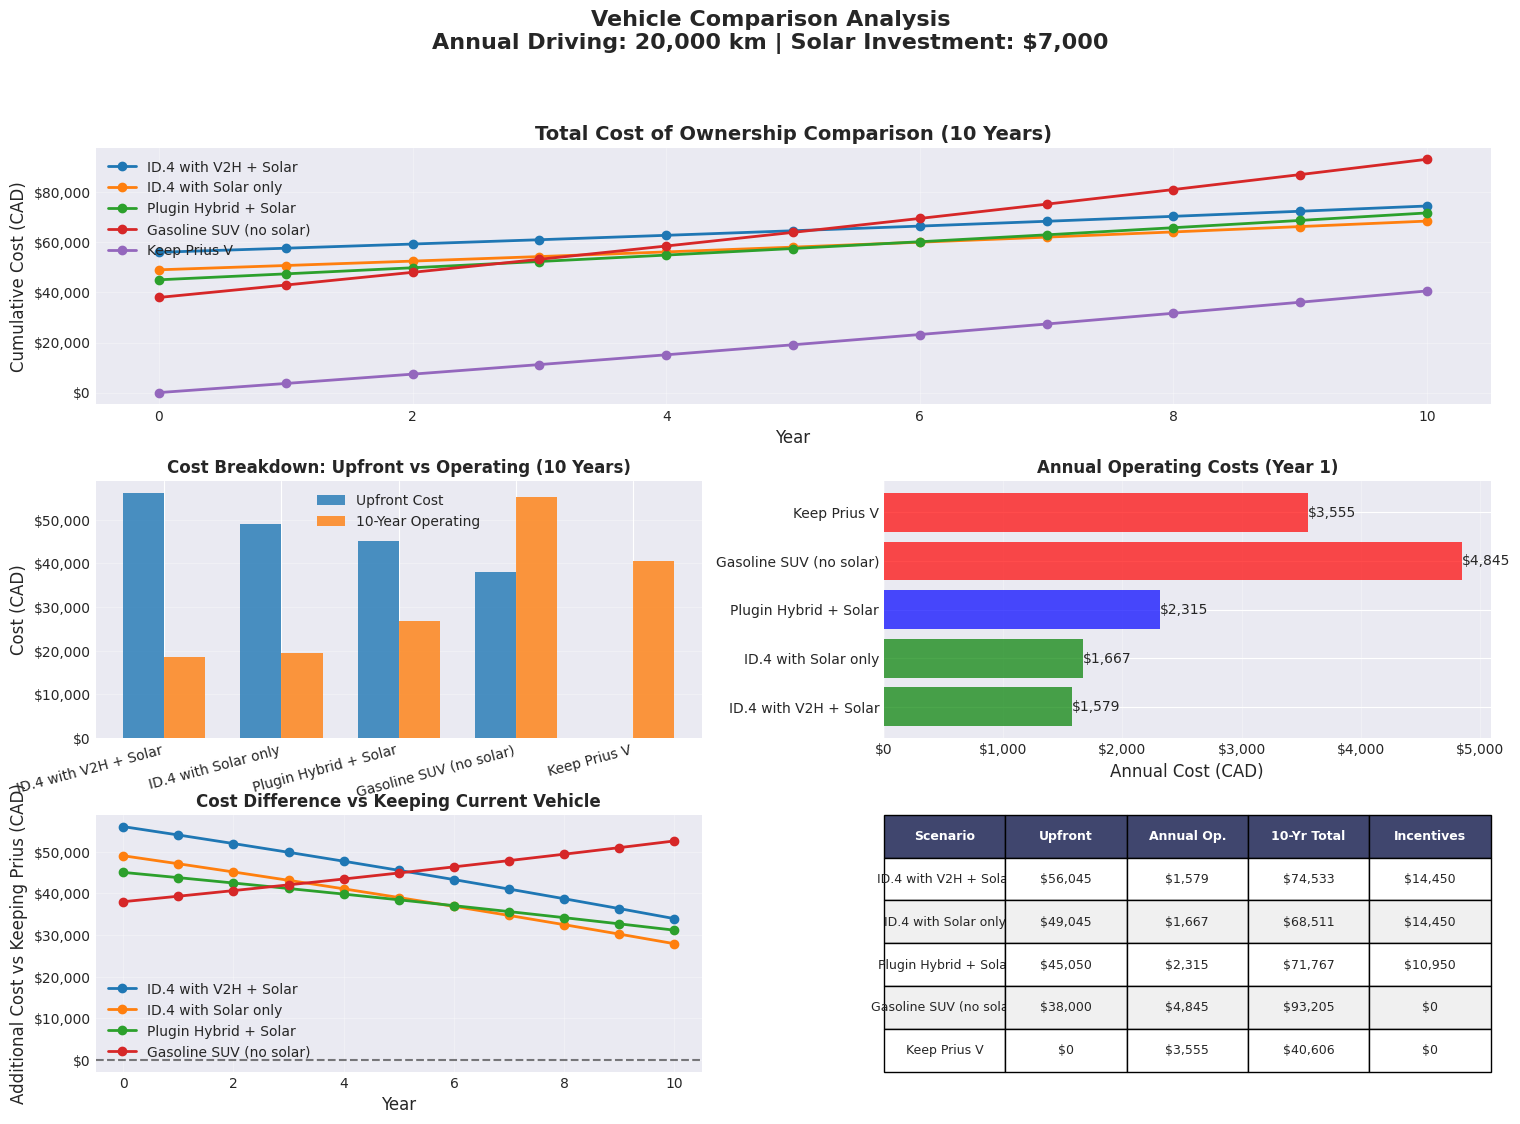


                         DETAILED COMPARISON SUMMARY

ID.4 WITH V2H + SOLAR:
  Upfront Cost:           $ 56,045.00
    • V2H charger:     $  7,900.00
    • Solar array (net):  $    150.00
  Annual Energy Cost:     $    331.55
  Annual Maintenance:     $    500.00
  Annual Tire Cost:       $    835.00
  Annual V2H Savings:    -$     87.60
  Total Annual Operating: $  1,578.95
  10-Year Total Cost:     $ 74,533.03
  Incentives Received:    $ 14,450.00

ID.4 WITH SOLAR ONLY:
  Upfront Cost:           $ 49,045.00
    • Level 2 charger:     $    900.00
    • Solar array (net):  $    150.00
  Annual Energy Cost:     $    331.55
  Annual Maintenance:     $    500.00
  Annual Tire Cost:       $    835.00
  Total Annual Operating: $  1,666.55
  10-Year Total Cost:     $ 68,511.38
  Incentives Received:    $ 14,450.00

PLUGIN HYBRID + SOLAR:
  Upfront Cost:           $ 45,050.00
    • Level 2 charger:     $    900.00
    • Solar array (net):  $    150.00
  Annual Energy Cost:     $    959.61
  

In [11]:
def create_comparison_dashboard(annual_km, solar_cost):
    """
    Create comprehensive comparison dashboard
    
    Scenarios explained:
    - ID.4 with V2H + Solar: Full setup with backup power capability
    - ID.4 with Solar only: EV with solar, standard Level 2 charger (no V2H)
    - Plugin Hybrid + Solar: PHEV with solar for electric portion
    - Gasoline SUV: No solar (ICE vehicle)
    - Keep Prius V: Current vehicle, no additional costs
    """
    # Calculate TCO for all scenarios
    scenarios = {
        'ID.4 with V2H + Solar': calculate_total_cost_of_ownership(
            'VW ID.4 Pro AWD', annual_km, solar_cost, include_v2h=True),
        'ID.4 with Solar only': calculate_total_cost_of_ownership(
            'VW ID.4 Pro AWD', annual_km, solar_cost, include_v2h=False),
        'Plugin Hybrid + Solar': calculate_total_cost_of_ownership(
            'Plugin Hybrid', annual_km, solar_cost),
        'Gasoline SUV (no solar)': calculate_total_cost_of_ownership(
            'Gasoline SUV', annual_km, 0),
        'Keep Prius V': calculate_total_cost_of_ownership(
            'Current Prius V', annual_km, 0)
    }
    
    # Print scenario breakdown
    print("\n" + "="*80)
    print(" " * 25 + "SCENARIO BREAKDOWN")
    print("="*80)
    print("\nID.4 with V2H + Solar:")
    print("  • VW ID.4 Pro AWD ($54,995 - $7,000 Quebec rebate)")
    print("  • V2H bidirectional charger ($8,500 - $600 rebate = $7,900)")
    print("  • 5kW solar array ($7,000 - $6,850 rebates = $150)")
    print("  • Enables: Backup power + Rate arbitrage + Solar charging")
    
    print("\nID.4 with Solar only:")
    print("  • VW ID.4 Pro AWD ($54,995 - $7,000 Quebec rebate)")
    print("  • Standard Level 2 charger ($1,500 - $600 rebate = $900)")
    print("  • 5kW solar array ($7,000 - $6,850 rebates = $150)")
    print("  • Enables: Solar charging (no backup power)")
    
    print("\nPlugin Hybrid + Solar:")
    print("  • Toyota RAV4 Prime or similar ($47,500 - $3,500 Quebec rebate)")
    print("  • Standard Level 2 charger ($1,500 - $600 rebate = $900)")
    print("  • 5kW solar array ($7,000 - $6,850 rebates = $150)")
    print("  • Enables: 70% electric driving + gas backup")
    
    print("\nGasoline SUV (no solar):")
    print("  • Comparable SUV (~$38,000, no rebates)")
    print("  • No charger needed")
    print("  • No solar installation")
    
    print("\nKeep Prius V:")
    print("  • No purchase cost (already owned)")
    print("  • No additional equipment")
    print("="*80 + "\n")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Cumulative Cost Over Time
    ax1 = fig.add_subplot(gs[0, :])
    for name, data in scenarios.items():
        ax1.plot(range(11), data['cumulative_cost'], marker='o', label=name, linewidth=2)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Cumulative Cost (CAD)', fontsize=12)
    ax1.set_title('Total Cost of Ownership Comparison (10 Years)', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 2. Cost Breakdown Bar Chart
    ax2 = fig.add_subplot(gs[1, 0])
    scenario_names = list(scenarios.keys())
    upfront_costs = [scenarios[s]['upfront_cost'] for s in scenario_names]
    operating_costs_10yr = [scenarios[s]['total_10yr_cost'] - scenarios[s]['upfront_cost'] 
                           for s in scenario_names]
    
    x = np.arange(len(scenario_names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, upfront_costs, width, label='Upfront Cost', alpha=0.8)
    bars2 = ax2.bar(x + width/2, operating_costs_10yr, width, label='10-Year Operating', alpha=0.8)
    
    ax2.set_ylabel('Cost (CAD)', fontsize=12)
    ax2.set_title('Cost Breakdown: Upfront vs Operating (10 Years)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names, rotation=15, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 3. Annual Operating Costs
    ax3 = fig.add_subplot(gs[1, 1])
    annual_operating = [scenarios[s]['total_annual_operating'] for s in scenario_names]
    colors = ['green' if 'ID.4' in s else 'blue' if 'Hybrid' in s else 'red' 
              for s in scenario_names]
    bars = ax3.barh(scenario_names, annual_operating, color=colors, alpha=0.7)
    ax3.set_xlabel('Annual Cost (CAD)', fontsize=12)
    ax3.set_title('Annual Operating Costs (Year 1)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add values on bars
    for bar in bars:
        width = bar.get_width()
        ax3.text(width, bar.get_y() + bar.get_height()/2, 
                f'${width:,.0f}', ha='left', va='center', fontsize=10)
    
    # 4. Payback Analysis vs Keeping Prius
    ax4 = fig.add_subplot(gs[2, 0])
    baseline_cost = scenarios['Keep Prius V']['cumulative_cost']
    
    for name, data in scenarios.items():
        if name != 'Keep Prius V':
            payback = np.array(data['cumulative_cost']) - np.array(baseline_cost)
            ax4.plot(range(11), payback, marker='o', label=name, linewidth=2)
    
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Year', fontsize=12)
    ax4.set_ylabel('Additional Cost vs Keeping Prius (CAD)', fontsize=12)
    ax4.set_title('Cost Difference vs Keeping Current Vehicle', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 5. Summary Table
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('tight')
    ax5.axis('off')
    
    table_data = []
    for name, data in scenarios.items():
        table_data.append([
            name,
            f"${data['upfront_cost']:,.0f}",
            f"${data['total_annual_operating']:,.0f}",
            f"${data['total_10yr_cost']:,.0f}",
            f"${data['incentives_received']:,.0f}"
        ])
    
    table = ax5.table(cellText=table_data,
                     colLabels=['Scenario', 'Upfront', 'Annual Op.', '10-Yr Total', 'Incentives'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(5):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    plt.suptitle(f'Vehicle Comparison Analysis\nAnnual Driving: {annual_km:,} km | Solar Investment: ${solar_cost:,}',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    
    # Print detailed summary
    print("\n" + "="*80)
    print(" " * 25 + "DETAILED COMPARISON SUMMARY")
    print("="*80)
    
    for name, data in scenarios.items():
        print(f"\n{name.upper()}:")
        print(f"  Upfront Cost:           ${data['upfront_cost']:>10,.2f}")
        if data.get('charger_cost', 0) > 0:
            charger_type = 'V2H charger' if 'V2H' in name else 'Level 2 charger'
            print(f"    • {charger_type}:     ${data['charger_cost']:>10,.2f}")
        if 'Solar' in name:
            solar_net = max(0, solar_cost - INCENTIVES['federal_solar'] - INCENTIVES['quebec_solar_max'])
            print(f"    • Solar array (net):  ${solar_net:>10,.2f}")
        print(f"  Annual Energy Cost:     ${data['annual_energy_cost']:>10,.2f}")
        print(f"  Annual Maintenance:     ${data['annual_maintenance']:>10,.2f}")
        print(f"  Annual Tire Cost:       ${data['annual_tire_cost']:>10,.2f}")
        if data['annual_v2h_savings'] > 0:
            print(f"  Annual V2H Savings:    -${data['annual_v2h_savings']:>10,.2f}")
        print(f"  Total Annual Operating: ${data['total_annual_operating']:>10,.2f}")
        print(f"  10-Year Total Cost:     ${data['total_10yr_cost']:>10,.2f}")
        print(f"  Incentives Received:    ${data['incentives_received']:>10,.2f}")
    
    # Find best option
    best_option = min(scenarios.items(), key=lambda x: x[1]['total_10yr_cost'])
    print("\n" + "="*80)
    print(f"BEST OPTION (Lowest 10-Year Cost): {best_option[0]}")
    print(f"Total Cost: ${best_option[1]['total_10yr_cost']:,.2f}")
    print("="*80)

# Run initial analysis
create_comparison_dashboard(20000, 7000)

## 9. Monthly Grid Power and Cost Analysis

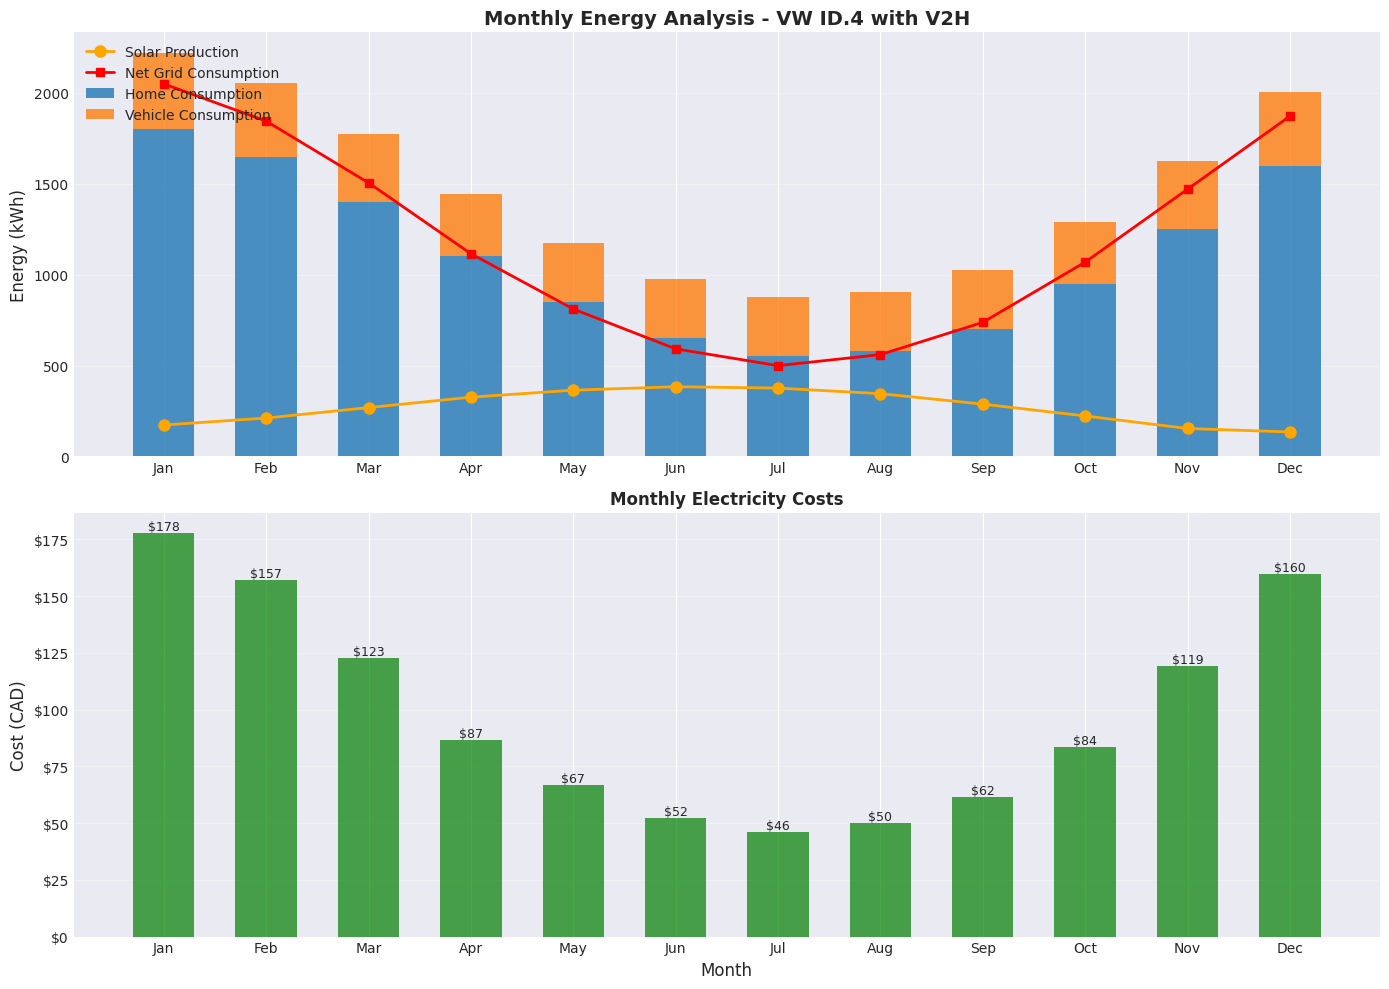


MONTHLY ANALYSIS - VW ID.4 with V2H

Annual Totals:
  Home Consumption:          13,080 kWh
  Vehicle Consumption:        4,290 kWh
  Total Consumption:         17,370 kWh
  Solar Production:           3,243 kWh
  Self-Consumption:           3,243 kWh (18.7%)
  Grid Consumption:          14,127 kWh

  Total Annual Cost:     $  1,183.85
  Average Monthly Cost:  $     98.65



In [12]:
def analyze_monthly_grid_usage(scenario_name, annual_km, solar_cost):
    """
    Detailed monthly analysis of grid power usage and costs
    """
    if 'ID.4' in scenario_name:
        vehicle = VEHICLES['VW ID.4 Pro AWD']
        has_solar = True
    elif 'Hybrid' in scenario_name:
        vehicle = VEHICLES['Plugin Hybrid']
        has_solar = True
    else:
        vehicle = VEHICLES['Gasoline SUV']
        has_solar = False
    
    monthly_km = annual_km / 12
    
    # Calculate monthly data
    monthly_data = []
    for month in range(12):
        # Base home consumption from Hydro data
        home_consumption = hydro_data.iloc[month]['consumption_kwh']
        
        # Vehicle energy consumption
        if vehicle['type'] == 'BEV':
            temp_correction = [1.3, 1.25, 1.15, 1.05, 1.0, 1.0, 
                             1.0, 1.0, 1.0, 1.05, 1.15, 1.25][month]
            vehicle_kwh = (monthly_km * vehicle['efficiency_kwh_per_100km'] / 100) * temp_correction
        elif vehicle['type'] == 'PHEV':
            electric_km = monthly_km * 0.7
            vehicle_kwh = electric_km * vehicle['efficiency_kwh_per_100km'] / 100
        else:
            vehicle_kwh = 0
        
        # Total consumption
        total_consumption = home_consumption + vehicle_kwh
        
        # Solar production
        solar_production = solar_production_monthly[month] if has_solar else 0
        
        # Net grid consumption
        net_grid_consumption = max(0, total_consumption - solar_production)
        
        # Calculate cost
        monthly_cost = calculate_electricity_cost(net_grid_consumption, 0)
        
        monthly_data.append({
            'month': hydro_data.iloc[month]['month'],
            'home_kwh': home_consumption,
            'vehicle_kwh': vehicle_kwh,
            'total_kwh': total_consumption,
            'solar_kwh': solar_production,
            'grid_kwh': net_grid_consumption,
            'cost': monthly_cost
        })
    
    df = pd.DataFrame(monthly_data)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Energy consumption stacked bar
    x = np.arange(len(df))
    width = 0.6
    
    ax1.bar(x, df['home_kwh'], width, label='Home Consumption', alpha=0.8)
    ax1.bar(x, df['vehicle_kwh'], width, bottom=df['home_kwh'], 
           label='Vehicle Consumption', alpha=0.8)
    
    if has_solar:
        ax1.plot(x, df['solar_kwh'], color='orange', marker='o', 
                linewidth=2, markersize=8, label='Solar Production')
    
    ax1.plot(x, df['grid_kwh'], color='red', marker='s', 
            linewidth=2, markersize=6, label='Net Grid Consumption')
    
    ax1.set_ylabel('Energy (kWh)', fontsize=12)
    ax1.set_title(f'Monthly Energy Analysis - {scenario_name}', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['month'])
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Monthly costs
    ax2.bar(x, df['cost'], width, color='green', alpha=0.7)
    ax2.set_ylabel('Cost (CAD)', fontsize=12)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_title('Monthly Electricity Costs', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['month'])
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))
    
    # Add value labels on bars
    for i, cost in enumerate(df['cost']):
        ax2.text(i, cost, f'${cost:.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*70}")
    print(f"MONTHLY ANALYSIS - {scenario_name}")
    print(f"{'='*70}")
    print(f"\nAnnual Totals:")
    print(f"  Home Consumption:      {df['home_kwh'].sum():>10,.0f} kWh")
    print(f"  Vehicle Consumption:   {df['vehicle_kwh'].sum():>10,.0f} kWh")
    print(f"  Total Consumption:     {df['total_kwh'].sum():>10,.0f} kWh")
    if has_solar:
        print(f"  Solar Production:      {df['solar_kwh'].sum():>10,.0f} kWh")
        print(f"  Self-Consumption:      {min(df['total_kwh'].sum(), df['solar_kwh'].sum()):>10,.0f} kWh ({min(df['total_kwh'].sum(), df['solar_kwh'].sum())/df['total_kwh'].sum()*100:.1f}%)")
    print(f"  Grid Consumption:      {df['grid_kwh'].sum():>10,.0f} kWh")
    print(f"\n  Total Annual Cost:     ${df['cost'].sum():>10,.2f}")
    print(f"  Average Monthly Cost:  ${df['cost'].mean():>10,.2f}")
    print(f"{'='*70}\n")
    
    return df

# Analyze VW ID.4 with V2H
monthly_analysis_ev = analyze_monthly_grid_usage('VW ID.4 with V2H', 20000, 7000)

## 10. Interactive Widget Dashboard

In [13]:
# Create interactive sliders
annual_km_slider = IntSlider(
    value=20000,
    min=5000,
    max=40000,
    step=1000,
    description='Annual km:',
    style={'description_width': 'initial'},
    continuous_update=False
)

solar_cost_slider = IntSlider(
    value=7000,
    min=0,
    max=15000,
    step=500,
    description='Solar Cost ($):',
    style={'description_width': 'initial'},
    continuous_update=False
)

# Create interactive output
interactive_plot = interactive(
    create_comparison_dashboard,
    annual_km=annual_km_slider,
    solar_cost=solar_cost_slider
)

# Display
display(interactive_plot)

interactive(children=(IntSlider(value=20000, continuous_update=False, description='Annual km:', max=40000, min…

## 11. V2H Backup Power by Month (Interactive)

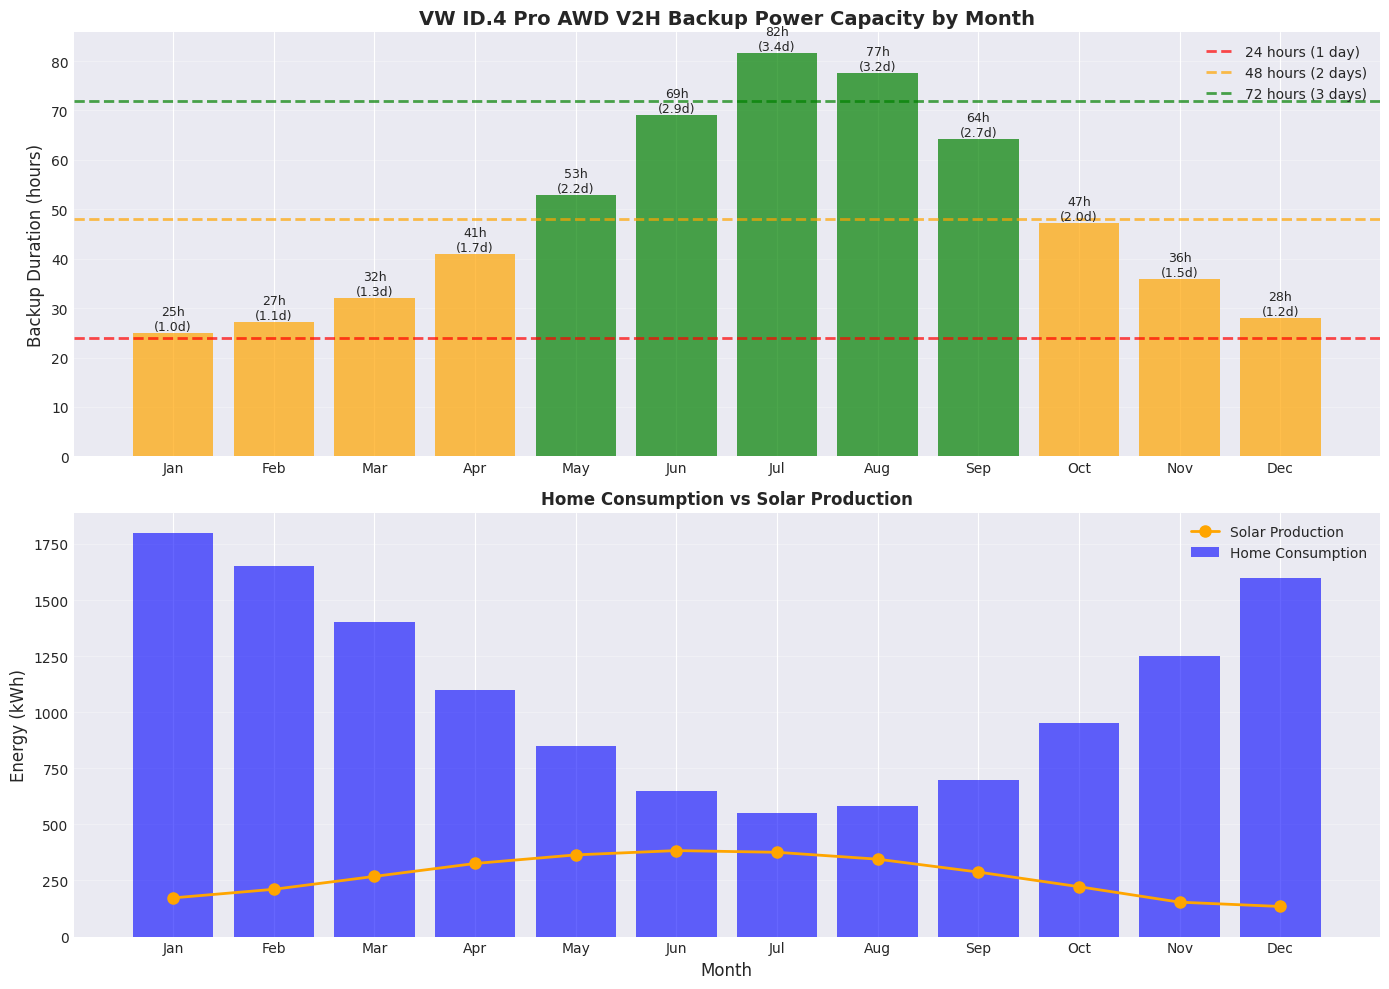


V2H BACKUP POWER SUMMARY

Battery Capacity Available for Backup: 61.6 kWh

Monthly Backup Duration:
  Jan:  25.0 hours ( 1.0 days) ⚠ Limited
  Feb:  27.2 hours ( 1.1 days) ⚠ Limited
  Mar:  32.1 hours ( 1.3 days) ⚠ Limited
  Apr:  40.9 hours ( 1.7 days) ⚠ Limited
  May:  52.9 hours ( 2.2 days) ⚠ Good
  Jun:  69.1 hours ( 2.9 days) ⚠ Good
  Jul:  81.7 hours ( 3.4 days) ✓ Excellent
  Aug:  77.5 hours ( 3.2 days) ✓ Excellent
  Sep:  64.2 hours ( 2.7 days) ⚠ Good
  Oct:  47.3 hours ( 2.0 days) ⚠ Limited
  Nov:  36.0 hours ( 1.5 days) ⚠ Limited
  Dec:  28.1 hours ( 1.2 days) ⚠ Limited

Average Backup: 48.5 hours (2.0 days)

Note: Backup duration assumes 80% of battery available (20% reserved for driving)
      Solar production extends backup during daylight hours.



In [14]:
def plot_v2h_backup_by_month():
    """
    Detailed V2H backup analysis showing:
    - Available backup hours per month
    - Critical load coverage
    - Solar contribution to backup
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    months = hydro_data['month']
    
    # Backup hours
    colors = ['red' if h < 24 else 'orange' if h < 48 else 'green' 
             for h in v2h_backup_hours]
    bars = ax1.bar(months, v2h_backup_hours, color=colors, alpha=0.7)
    
    ax1.axhline(y=24, color='red', linestyle='--', linewidth=2, 
               label='24 hours (1 day)', alpha=0.7)
    ax1.axhline(y=48, color='orange', linestyle='--', linewidth=2, 
               label='48 hours (2 days)', alpha=0.7)
    ax1.axhline(y=72, color='green', linestyle='--', linewidth=2, 
               label='72 hours (3 days)', alpha=0.7)
    
    ax1.set_ylabel('Backup Duration (hours)', fontsize=12)
    ax1.set_title('VW ID.4 Pro AWD V2H Backup Power Capacity by Month', 
                 fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, hours) in enumerate(zip(bars, v2h_backup_hours)):
        ax1.text(bar.get_x() + bar.get_width()/2, hours, 
                f'{hours:.0f}h\n({hours/24:.1f}d)',
                ha='center', va='bottom', fontsize=9)
    
    # Monthly consumption vs solar
    monthly_consumption = hydro_data['consumption_kwh']
    
    ax2.bar(months, monthly_consumption, alpha=0.6, label='Home Consumption', color='blue')
    ax2.plot(months, solar_production_monthly, color='orange', marker='o', 
            linewidth=2, markersize=8, label='Solar Production')
    
    ax2.set_ylabel('Energy (kWh)', fontsize=12)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_title('Home Consumption vs Solar Production', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print(f"\n{'='*70}")
    print("V2H BACKUP POWER SUMMARY")
    print(f"{'='*70}")
    print(f"\nBattery Capacity Available for Backup: {VEHICLES['VW ID.4 Pro AWD']['usable_battery_kwh'] * 0.8:.1f} kWh")
    print(f"\nMonthly Backup Duration:")
    for month, hours in zip(months, v2h_backup_hours):
        days = hours / 24
        status = '✓ Excellent' if hours >= 72 else '⚠ Good' if hours >= 48 else '⚠ Limited'
        print(f"  {month:>3}: {hours:>5.1f} hours ({days:>4.1f} days) {status}")
    print(f"\nAverage Backup: {np.mean(v2h_backup_hours):.1f} hours ({np.mean(v2h_backup_hours)/24:.1f} days)")
    print(f"\nNote: Backup duration assumes 80% of battery available (20% reserved for driving)")
    print(f"      Solar production extends backup during daylight hours.")
    print(f"{'='*70}\n")

plot_v2h_backup_by_month()

## 12. Recommendations and Key Insights

In [15]:
def generate_recommendations(annual_km, solar_cost):
    """
    Generate personalized recommendations based on analysis
    """
    # Run calculations
    scenarios = {
        'ID.4 with V2H': calculate_total_cost_of_ownership(
            'VW ID.4 Pro AWD', annual_km, solar_cost, include_v2h=True),
        'ID.4 without V2H': calculate_total_cost_of_ownership(
            'VW ID.4 Pro AWD', annual_km, solar_cost, include_v2h=False),
        'Plugin Hybrid': calculate_total_cost_of_ownership(
            'Plugin Hybrid', annual_km, solar_cost),
        'Gasoline SUV': calculate_total_cost_of_ownership(
            'Gasoline SUV', annual_km, 0),
        'Keep Prius V': calculate_total_cost_of_ownership(
            'Current Prius V', annual_km, 0)
    }
    
    print("\n" + "="*80)
    print(" " * 30 + "RECOMMENDATIONS")
    print("="*80)
    
    # Find best options
    sorted_scenarios = sorted(scenarios.items(), key=lambda x: x[1]['total_10yr_cost'])
    
    print(f"\n📊 RANKING BY 10-YEAR TOTAL COST:\n")
    for i, (name, data) in enumerate(sorted_scenarios, 1):
        print(f"  {i}. {name:20s} ${data['total_10yr_cost']:>10,.0f}")
    
    print(f"\n\n💡 KEY INSIGHTS:\n")
    
    # VW ID.4 with V2H analysis
    v2h_data = scenarios['ID.4 with V2H']
    no_v2h_data = scenarios['ID.4 without V2H']
    v2h_premium = v2h_data['upfront_cost'] - no_v2h_data['upfront_cost']
    v2h_annual_savings = no_v2h_data['total_annual_operating'] - v2h_data['total_annual_operating']
    v2h_payback = v2h_premium / v2h_annual_savings if v2h_annual_savings > 0 else float('inf')
    
    print(f"1. V2H ECONOMICS:")
    print(f"   • V2H equipment adds ${v2h_premium:,.0f} upfront")
    print(f"   • Annual savings from rate arbitrage: ${v2h_annual_savings:,.0f}")
    print(f"   • Payback period: {v2h_payback:.1f} years")
    if v2h_payback > 10:
        print(f"   ⚠ V2H may not pay for itself in 10 years based purely on energy arbitrage")
        print(f"   ✓ However, backup power capability has significant value for resilience")
    else:
        print(f"   ✓ V2H pays for itself through energy savings")
    
    # Solar analysis
    ev_no_solar = calculate_total_cost_of_ownership('VW ID.4 Pro AWD', annual_km, 0, include_v2h=False)
    ev_with_solar = scenarios['ID.4 without V2H']
    solar_benefit = ev_no_solar['total_10yr_cost'] - ev_with_solar['total_10yr_cost']
    
    print(f"\n2. SOLAR INVESTMENT:")
    print(f"   • Net solar cost after incentives: ${ev_with_solar['upfront_cost'] - VEHICLES['VW ID.4 Pro AWD']['price_cad'] + INCENTIVES['federal_ev'] + INCENTIVES['quebec_ev']:,.0f}")
    print(f"   • 10-year benefit: ${solar_benefit:,.0f}")
    print(f"   • Annual solar production: {sum(solar_production_monthly):,.0f} kWh")
    if solar_benefit > 0:
        print(f"   ✓ Solar provides positive ROI over 10 years")
    
    # EV vs Gas comparison
    ev_vs_gas = scenarios['Gasoline SUV']['total_10yr_cost'] - scenarios['ID.4 without V2H']['total_10yr_cost']
    
    print(f"\n3. ELECTRIC vs GASOLINE:")
    print(f"   • 10-year savings with EV: ${ev_vs_gas:,.0f}")
    print(f"   • Annual fuel savings: ~${(scenarios['Gasoline SUV']['annual_energy_cost'] - scenarios['ID.4 without V2H']['annual_energy_cost']):,.0f}")
    if ev_vs_gas > 0:
        print(f"   ✓ EV is more economical over 10 years")
    
    # Environmental impact
    gas_emissions = annual_km * VEHICLES['Gasoline SUV']['fuel_efficiency_l_per_100km'] / 100 * 2.3  # kg CO2 per liter
    ev_emissions = annual_km * VEHICLES['VW ID.4 Pro AWD']['efficiency_kwh_per_100km'] / 100 * 0.001  # Quebec hydro ~0.001 kg/kWh
    
    print(f"\n4. ENVIRONMENTAL IMPACT (Annual):")
    print(f"   • Gasoline SUV: ~{gas_emissions:,.0f} kg CO₂")
    print(f"   • VW ID.4 (Quebec hydro): ~{ev_emissions:,.0f} kg CO₂")
    print(f"   • Annual reduction: {gas_emissions - ev_emissions:,.0f} kg CO₂ ({(1-ev_emissions/gas_emissions)*100:.0f}% reduction)")
    
    print(f"\n\n🎯 FINAL RECOMMENDATION:\n")
    
    best_option = sorted_scenarios[0][0]
    
    if best_option == 'ID.4 with V2H':
        print(f"   ✓ VW ID.4 Pro AWD WITH V2H is the best long-term choice")
        print(f"     • Lowest 10-year total cost")
        print(f"     • Backup power capability ({min(v2h_backup_hours):.0f}-{max(v2h_backup_hours):.0f} hours)")
        print(f"     • Rate arbitrage savings")
        print(f"     • Maximum environmental benefit")
    elif best_option == 'ID.4 without V2H':
        print(f"   ✓ VW ID.4 Pro AWD WITHOUT V2H offers best value")
        print(f"     • Lower upfront cost than V2H version")
        print(f"     • Still benefits from solar and low electricity rates")
        print(f"     • Consider V2H if backup power is priority")
    elif best_option == 'Keep Prius V':
        print(f"   ✓ KEEPING YOUR PRIUS V is most economical")
        print(f"     • Zero upfront cost")
        print(f"     • Already efficient vehicle")
        print(f"     • Consider upgrading when Prius needs replacement")
    else:
        print(f"   ✓ {best_option.upper()} provides best value for your situation")
    
    print(f"\n" + "="*80 + "\n")

# Generate recommendations
generate_recommendations(20000, 7000)


                              RECOMMENDATIONS

📊 RANKING BY 10-YEAR TOTAL COST:

  1. Keep Prius V         $    40,606
  2. ID.4 without V2H     $    68,511
  3. Plugin Hybrid        $    71,767
  4. ID.4 with V2H        $    74,533
  5. Gasoline SUV         $    93,205


💡 KEY INSIGHTS:

1. V2H ECONOMICS:
   • V2H equipment adds $7,000 upfront
   • Annual savings from rate arbitrage: $88
   • Payback period: 79.9 years
   ⚠ V2H may not pay for itself in 10 years based purely on energy arbitrage
   ✓ However, backup power capability has significant value for resilience

2. SOLAR INVESTMENT:
   • Net solar cost after incentives: $1,050
   • 10-year benefit: $-150
   • Annual solar production: 3,243 kWh

3. ELECTRIC vs GASOLINE:
   • 10-year savings with EV: $24,694
   • Annual fuel savings: ~$2,803
   ✓ EV is more economical over 10 years

4. ENVIRONMENTAL IMPACT (Annual):
   • Gasoline SUV: ~4,370 kg CO₂
   • VW ID.4 (Quebec hydro): ~4 kg CO₂
   • Annual reduction: 4,366 kg CO₂ (100% 

## 13. Setup Instructions

### Prerequisites
```bash
pip install jupyter ipywidgets matplotlib pandas numpy requests python-dotenv
pip install hydroqc  # For Hydro-Quebec API access
```

### Hydro-Quebec Credentials
Create a file named `.env` in the same directory:
```bash
HYDRO_USERNAME=your_hydroquebec_username
HYDRO_PASSWORD=your_password
HYDRO_CONTRACT_ID=your_contract_id
HYDRO_CUSTOMER_ID=your_customer_id
```

⚠️ **IMPORTANT**: Add `.env` to your `.gitignore` file!

### Running the Notebook
1. Open JupyterLab: `jupyter lab`
2. Open this notebook
3. Run all cells: Cell → Run All
4. Use the interactive sliders to adjust parameters

### Data Sources
- Vehicle specifications: Manufacturer data and real-world reviews
- Electricity rates: Hydro-Québec Rate D and Flex D (2024)
- Government incentives: Canadian and Quebec programs (2024/2025)
- Solar data: Natural Resources Canada PVWatts for Montreal
- Climate data: Environment Canada historical averages